<a href="https://colab.research.google.com/github/SEC-API-io/sec-api-cookbook/blob/main/notebooks/form-8k/8k-item-5-02-tutorial-website.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Analysis of Officer and Director Change Reports

We illustrate how to perform an exploratory data analysis on disclosures informing investors about changes of certain officers and directors of publicly traded companies on U.S. stock exchanges. These changes are disclosed in Form 8-K filings with the SEC, specifically under Item 5.02, titled "Departure of Directors or Certain Officers; Election of Directors; Appointment of Certain Officers: Compensatory Arrangements of Certain Officers." These disclosures are presented in text form by companies. Utilizing our Structured Data API, we extract and structure the relevant information from the text, making it available for detailed analysis.

Our analysis will focus on several key areas:

- Number of Item 5.02 disclosures made each year from 2004 to 2024, per quarter, month and at what time of the day (pre-market, regular market, after-market)
- Distribution of disclosures across structured data fields, such as the proportion of disclosures reporting appointments and departures.
- Appointments: number per year to certain position and statistics such as histograms of the age of the appointed person and the annual compensation.
- Departures: number per per year and their reasons and the rate if disagreements in connection with these departures.
- Amendments: distribution of amendments across term duration change, compensation changes and compensation types.
- Changes of the Board of Directors size
- Eligibility of bonus plans

## Data Loading and Preparation

To load and prepare the dataset of over 250,000 structured data objects from Item 5.02 disclosures spanning 2004 to 2024, we utilize the [Form 8-K Item 5.02 Structured Data API](https://sec-api.io/docs/form-8k-data-item5-2-search-api). The following code handles data loading and preparation by executing multiple download processes in parallel, significantly reducing downloading time. Once downloaded, all structured data objects are saved in JSONL format to `./form-8k-item-5-02-structured-data.jsonl`, which will serve as the primary dataset for the analysis. Downloading the entire dataset may take up to 10 minutes.

In [1]:
import os
import json
import random 
import time
import sys
import re
# from multiprocessing import Pool # use in .py files only
from concurrent.futures import ThreadPoolExecutor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
import matplotlib.ticker as mtick
import seaborn as sns

style.use("default")

params = {
    "axes.labelsize": 8, "font.size": 8, "legend.fontsize": 8,
    "xtick.labelsize": 8, "ytick.labelsize": 8, "font.family": "sans-serif",
    "axes.spines.top": False, "axes.spines.right": False, "grid.color": "grey",
    "axes.grid": True, "axes.grid.axis": "y", "grid.alpha": 0.5, "grid.linestyle": ":",
}

plt.rcParams.update(params)

In [ ]:
!pip install sec-api

In [ ]:
from sec_api import Form_8K_Item_X_Api

item_X_api = Form_8K_Item_X_Api("YOUR_API_KEY")

YEARS = range(2024, 2003, -1) # from 2024 to 2004
TEMP_FILE_TEMPLATE = "./temp_file_{}.jsonl"
TARGET_FILE = "./form-8k-item-5-02-structured-data.jsonl"


def process_year(year):
    backoff_time = random.randint(10, 800) / 1000
    print(f"Starting year {year} with backoff time {backoff_time:,}s"); sys.stdout.flush()
    time.sleep(backoff_time)

    tmp_filename = TEMP_FILE_TEMPLATE.format(year)
    tmp_file = open(tmp_filename, "a")

    for month in range(12, 0, -1):
        search_from = 0
        month_counter = 0

        while True:
            query = f"item5_02:* AND filedAt:[{year}-{month:02d}-01 TO {year}-{month:02d}-31]"
            searchRequest = {
                "query": query,
                "from": search_from,
                "size": "50",
                "sort": [{"filedAt": {"order": "desc"}}],
            }

            response = None
            try:
                response = item_X_api.get_data(searchRequest)
            except Exception as e:
                print(f"{year}-{month:02d} error: {e}"); sys.stdout.flush()
                continue

            if response == None or len(response["data"]) == 0:
                break

            search_from += 50
            month_counter += len(response["data"])
            jsonl_data = "\n".join([json.dumps(entry) for entry in response["data"]])
            tmp_file.write(jsonl_data + "\n")

        print(f"Finished loading {month_counter} Item 5.02 for {year}-{month:02d}")
        sys.stdout.flush()

    tmp_file.close()

    return year



if not os.path.exists(TARGET_FILE):
    with ThreadPoolExecutor(max_workers=4) as pool:
        processed_years = list(pool.map(process_year, YEARS))
    print("Finished processing all years.", processed_years)

    # merge the temporary files into one final file
    with open(TARGET_FILE, "a") as outfile:
        for year in YEARS:
            temp_file = TEMP_FILE_TEMPLATE.format(year)
            if os.path.exists(temp_file):
                with open(temp_file, "r") as infile:
                    outfile.write(infile.read())
else:
    print("File already exists. Skipping download.")

File already exists. Skipping download.


In [5]:
structured_data = pd.read_json(TARGET_FILE, lines=True)

structured_data["filedAt"] = pd.to_datetime(structured_data["filedAt"], utc=True)
structured_data["filedAt"] = structured_data["filedAt"].dt.tz_convert("US/Eastern")
structured_data = structured_data.sort_values("filedAt", ascending=True).reset_index(drop=True)
structured_data.drop_duplicates("accessionNo", keep="first", inplace=True)
structured_data["year"] = structured_data["filedAt"].dt.year
structured_data["month"] = structured_data["filedAt"].dt.month
structured_data["dayOfWeek"] = structured_data["filedAt"].dt.day_name()
# filedAtClass: preMarket (4:00AM-9:30AM), regularMarket (9:30AM-4:00PM), afterMarket (4:00PM-8:00PM)
structured_data["filedAtClass"] = structured_data["filedAt"].apply(
    lambda x: (
        "preMarket"
        if x.hour < 9 or (x.hour == 9 and x.minute < 30)
        else (
            "regularMarket"
            if x.hour < 16
            else "afterMarket" if x.hour < 20 else "other"
        )
    )
)
# convert long-form of each item into item id only, e.g. "Item 4.02: ..." => "4.02"
structured_data["items"] = structured_data["items"].apply(
    lambda items: [re.search(r"\d+\.\d+", x).group(0) if x else None for x in items]
)
# explode column "item5_02" into multiple columns
# where each column is a key-value pair of the JSON object
# and drop all structured data columns for items, eg "item4_01"
item_cols = list(
    structured_data.columns[
        structured_data.columns.str.contains(r"item\d+_", case=False)
    ]
)
structured_data = pd.concat(
    [
        structured_data.drop(item_cols, axis=1),
        structured_data["item5_02"].apply(pd.Series),
    ],
    axis=1,
)

In [6]:
unique_years = structured_data["year"].nunique()
unique_companies = structured_data["cik"].nunique()
unique_filings = structured_data["accessionNo"].nunique()
min_year = structured_data["year"].min()
max_year = structured_data["year"].max()
print("Loaded dataframe with structured personnel change data from Form 8-K Item 5.02 filings")
print(f"Number of filings: {unique_filings:,}")
print(f"Number of records: {len(structured_data):,}")
print(f"Number of years: {unique_years:,} ({min_year}-{max_year})")
print(f"Number of unique companies: {unique_companies:,}")

structured_data.head()

Loaded dataframe with structured personnel change data from Form 8-K Item 5.02 filings
Number of filings: 250,956
Number of records: 250,956
Number of years: 21 (2004-2024)
Number of unique companies: 18,056


,id,accessionNo,formType,filedAt,periodOfReport,cik,ticker,companyName,items,year,month,dayOfWeek,filedAtClass,keyComponents,personnelChanges,attachments,organizationChanges,bonusPlans
0,1f87b5f2eb5ebcbe4a33a3b7a62daf64,0001125282-04-004109,8-K,2004-08-23 09:51:12-04:00,2004-08-23,1022671,STLD,STEEL DYNAMICS INC,[5.02],2004,8,Monday,regularMarket,Tracy L. Shellabarger resigned as CFO to pursu...,"[{'type': 'departure', 'departureType': 'resig...",NaN,NaN,NaN
1,34f998c74cf305575e1c99af88687741,0001104659-04-025282,8-K,2004-08-23 11:31:33-04:00,2004-08-23,1038363,NaN,METALS USA INC,[5.02],2004,8,Monday,regularMarket,Metals USA announced the retirement of E. L. (...,"[{'type': 'departure', 'departureType': 'retir...","[Text of Press Release Dated August 16, 2004]",NaN,NaN
2,aaf76daa3dbf9e814ba40d9b220a75c4,0000899715-04-000164,8-K,2004-08-23 12:35:47-04:00,2004-08-23,899715,SKT,TANGER FACTORY OUTLET CENTERS INC,[5.02],2004,8,Monday,regularMarket,The Board of Directors expanded from five to s...,"[{'type': 'appointment', 'effectiveDate': '200...",[Press release announcing expansion of the Com...,"{'organ': 'Board of Directors', 'details': 'Ex...",NaN
3,06f7d324ce85534dc7fc2cc0393db153,0001019056-04-001127,8-K,2004-08-23 13:16:24-04:00,2004-08-23,870228,SYBR,SYNERGY BRANDS INC,[5.02],2004,8,Monday,regularMarket,Michael Ferrone resigned as a director on the ...,"[{'type': 'departure', 'departureType': 'resig...",NaN,NaN,NaN
4,05035be548ee5e117923f7b6ca1030d1,0001104659-04-025325,8-K,2004-08-23 16:14:05-04:00,2004-08-17,1003214,SIMG,SILICON IMAGE INC,"[1.01, 1.02, 5.02, 9.01]",2004,8,Monday,afterMarket,Dale Brown was appointed as the Chief Accounti...,"[{'type': 'appointment', 'effectiveDate': '200...","[Amended and Restated Employment Agreement, da...",NaN,"[{'specificIndividuals': True, 'eligibleIndivi..."


## Vizualization of Officer and Director Change Disclosures over Time


In [7]:
item_5_02_counts = (
    structured_data.drop_duplicates(subset=["accessionNo"])
    .groupby(["year"])
    .size()
    .to_frame(name="count")
)

print(f"Item 5.02 counts from 2004 to 2024.")
item_5_02_counts.T

Item 5.02 counts from 2004 to 2024.


year,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
count,2988,9805,11441,17137,17589,14566,13294,13237,12832,12586,...,12611,11618,11353,11171,10976,10721,11456,11342,11044,10279


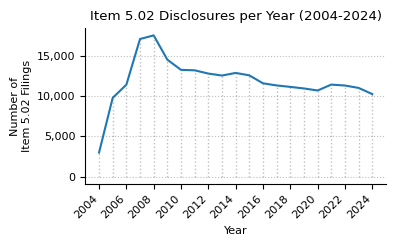

In [8]:
def plot_timeseries(ts, title):
    fig, ax = plt.subplots(figsize=(4, 2.5))
    ts["count"].plot(ax=ax, legend=False)
    ax.set_title(title)
    ax.set_xlabel("Year")
    ax.set_ylabel("Number of\nItem 5.02 Filings")
    ax.set_xticks(np.arange(2004, 2025, 2))
    ax.yaxis.set_major_formatter(mtick.StrMethodFormatter("{x:,.0f}"))
    ax.set_xlim(2003, 2025)
    ax.grid(axis="x")
    ax.set_axisbelow(True)
    plt.xticks(rotation=45, ha="right")

    for year in range(2004, 2025, 1):
        year_y_max = ts.loc[year, "count"]
        ax.vlines(year, 0, year_y_max, linestyles=":", colors="grey", alpha=0.5, lw=1)

    plt.tight_layout()
    plt.show()


plot_timeseries(
    item_5_02_counts,
    title="Item 5.02 Disclosures per Year (2004-2024)",
)

In [9]:
structured_data["qtr"] = structured_data["month"].apply(lambda x: (x - 1) // 3 + 1)

counts_qtr_yr_piv = (
    structured_data.groupby(["year", "qtr"]).size().unstack().fillna(0)
).astype(int)

print(f"Item 5.02 counts by quarter from 2004 to 2024.")
counts_qtr_yr_piv.T

Item 5.02 counts by quarter from 2004 to 2024.


year,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
qtr,,,,,,,,,,,,,,,,,,,,,
1,0,2397,2737,4772,5088,4573,3837,3939,3736,3543,...,3548,3382,3253,3164,3071,2943,3109,3279,3084,2794
2,0,2513,2575,4398,4591,3614,3472,3401,3328,3329,...,3305,3058,3035,2881,2948,2831,2947,2995,2920,2833
3,736,2416,2507,3831,3717,2974,2911,2920,2732,2683,...,2832,2529,2395,2452,2466,2416,2623,2534,2446,2237
4,2252,2479,3622,4136,4193,3405,3074,2977,3036,3031,...,2926,2649,2670,2674,2491,2531,2777,2534,2594,2415


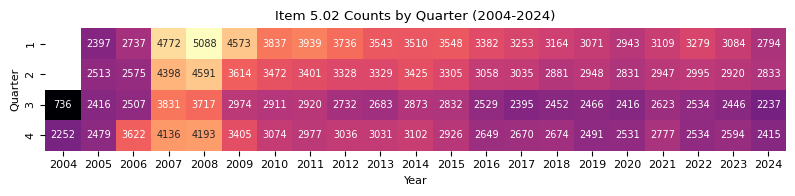

In [10]:
plt.figure(figsize=(8, 2))
sns.heatmap(
    counts_qtr_yr_piv.T,
    annot=True,  # Display the cell values
    fmt="d",  # Integer formatting
    cmap="magma",  # Color map
    cbar_kws={"label": "Count"},  # Colorbar label
    mask=counts_qtr_yr_piv.T == 0,  # Mask the cells with value 0
    cbar=False,
    annot_kws={"fontsize": 7},
)
plt.grid(False)
plt.title("Item 5.02 Counts by Quarter (2004-2024)")
plt.xlabel("Year")
plt.ylabel("Quarter")
plt.tight_layout()
plt.show()

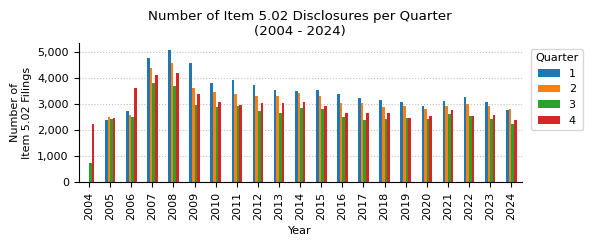

In [11]:
counts_qtr_yr = counts_qtr_yr_piv.stack().reset_index(name="count")

fig, ax = plt.subplots(figsize=(6, 2.5))
counts_qtr_yr_piv.plot(kind="bar", ax=ax, legend=True)
ax.legend(title="Quarter", loc="upper right", bbox_to_anchor=(1.15, 1))
ax.set_title("Number of Item 5.02 Disclosures per Quarter\n(2004 - 2024)")
ax.set_xlabel("Year")
ax.set_ylabel("Number of\nItem 5.02 Filings")
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter("{x:,.0f}"))
ax.grid(axis="x")
ax.set_axisbelow(True)
plt.tight_layout()
plt.show()

In [ ]:
counts_month_yr_piv = (
    structured_data.groupby(["year", "month"]).size().unstack().fillna(0)
).astype(int)

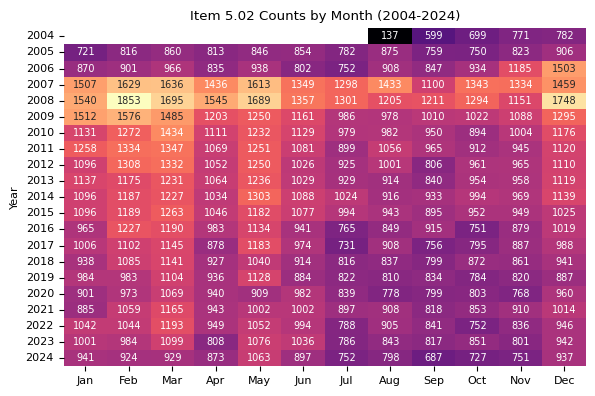

In [13]:
plt.figure(figsize=(6, 4))
sns.heatmap(
    counts_month_yr_piv,
    annot=True,
    fmt="d",
    cmap="magma",
    cbar_kws={"label": "Count"},
    mask=counts_month_yr_piv == 0,
    cbar=False,
    annot_kws={"size": 7},
)
# convert x-labels to month names: 1 => Jan, 2 => Feb, etc.
plt.xticks(
    ticks=np.arange(0.5, 12.5, 1),
    labels=[pd.to_datetime(str(i), format="%m").strftime("%b") for i in range(1, 13)],
)
plt.grid(False)
plt.title("Item 5.02 Counts by Month (2004-2024)")
plt.xlabel("")
plt.ylabel("Year")
plt.tight_layout()
plt.show()

In [14]:
print(f"Descriptive statistics for Item 5.02 counts by month from 2004 to 2024.")
month_stats = (
    counts_month_yr_piv.loc[2004:]
    .describe(percentiles=[0.025, 0.975])
    .round(0)
    .astype(int)
)
month_stats

Descriptive statistics for Item 5.02 counts by month from 2004 to 2024.


month,1,2,3,4,5,6,7,8,9,10,11,12
count,21,21,21,21,21,21,21,21,21,21,21,21
mean,1030,1125,1167,974,1113,980,860,904,866,900,936,1096
std,320,363,341,291,326,265,253,229,135,168,151,234
min,0,0,0,0,0,0,0,137,599,699,751,782
2.5%,360,408,430,404,423,401,366,458,643,713,760,834
50%,1006,1102,1190,949,1134,1002,839,908,840,872,910,1019
97.5%,1526,1741,1666,1490,1651,1353,1300,1319,1156,1318,1260,1626
max,1540,1853,1695,1545,1689,1357,1301,1433,1211,1343,1334,1748


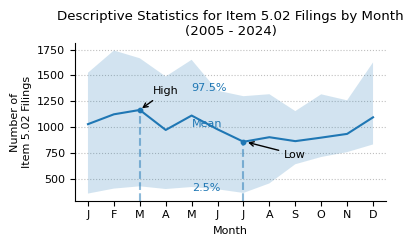

In [ ]:
def plot_box_plot_as_line(
    data: pd.DataFrame,
    x_months=True,
    title="",
    x_label="",
    x_pos_mean_label=2,
    pos_labels=None, 
    pos_high_low=None,
    y_label="",
    y_formatter=lambda x, p: "{:.0f}".format(int(x) / 1000),
    show_high_low_labels=True,
    show_inline_labels=True,
    show_bands=True,
    figsize=(4, 2.5),
    line_source="mean",
):
    fig, ax = plt.subplots(figsize=figsize)

    line_to_plot = data[line_source]
    lower_label = "2.5%"
    upper_label = "97.5%"
    lower = data[lower_label]
    upper = data[upper_label]

    line_to_plot.plot(ax=ax)

    if show_bands:
        ax.fill_between(line_to_plot.index, lower, upper, alpha=0.2)

    if x_months:
        ax.set_xlim(0.5, 12.5)
        ax.set_xticks(range(1, 13))
        ax.set_xticklabels(["J", "F", "M", "A", "M", "J", "J", "A", "S", "O", "N", "D"])

    ax.yaxis.set_major_formatter(mtick.FuncFormatter(y_formatter))
    ax.set_ylabel(y_label)
    ax.set_xlabel(x_label)
    ax.set_title(title)

    ymin, ymax = ax.get_ylim()
    y_scale = ymax - ymin

    max_x = int(line_to_plot.idxmax())
    max_y = line_to_plot.max()
    min_x = int(line_to_plot.idxmin())
    min_y = line_to_plot.min()

    ax.axvline(
        max_x,
        ymin=0,
        ymax=((max_y - ymin) / (ymax - ymin)),
        linestyle="dashed",
        color="tab:blue",
        alpha=0.5,
    )
    ax.scatter(max_x, max_y, color="tab:blue", s=10)
    ax.axvline(
        min_x,
        ymin=0,
        ymax=((min_y - ymin) / (ymax - ymin)),
        linestyle="dashed",
        color="tab:blue",
        alpha=0.5,
    )
    ax.scatter(min_x, min_y, color="tab:blue", s=10)

    x_pos_mean_label_int = int(x_pos_mean_label)
    if show_inline_labels:
        mean_x = x_pos_mean_label
        mean_y = line_to_plot.iloc[x_pos_mean_label_int] * 1.02
        upper_x = x_pos_mean_label
        upper_y = upper.iloc[x_pos_mean_label_int]
        lower_x = x_pos_mean_label
        lower_y = lower.iloc[x_pos_mean_label_int] * 0.95

        if pos_labels:
            mean_x = pos_labels["mean"]["x"]
            mean_y = pos_labels["mean"]["y"]
            upper_x = pos_labels["upper"]["x"]
            upper_y = pos_labels["upper"]["y"]
            lower_x = pos_labels["lower"]["x"]
            lower_y = pos_labels["lower"]["y"]

        ax.text(mean_x, mean_y, "Mean", color="tab:blue", fontsize=8)
        ax.text(upper_x, upper_y, upper_label, color="tab:blue", fontsize=8)
        ax.text(lower_x, lower_y, lower_label, color="tab:blue", fontsize=8)

    if show_high_low_labels:
        high_x_origin = max_x
        high_y_origin = max_y
        high_x_label = high_x_origin + 0.5
        high_y_label = high_y_origin + 0.1 * y_scale
        if pos_high_low:
            high_x_label = pos_high_low["high"]["x"]
            high_y_label = pos_high_low["high"]["y"]
        ax.annotate(
            "High",
            (high_x_origin, high_y_origin),
            xytext=(high_x_label, high_y_label),
            arrowprops=dict(facecolor="black", arrowstyle="->"),
        )

        low_x_origin = min_x * 1.01
        low_y_origin = min_y
        low_x_label = low_x_origin + 1.5
        low_y_label = low_y_origin - 0.1 * y_scale
        if pos_high_low:
            low_x_label = pos_high_low["low"]["x"]
            low_y_label = pos_high_low["low"]["y"]
        ax.annotate(
            "Low",
            (low_x_origin, low_y_origin),
            xytext=(low_x_label, low_y_label),
            arrowprops=dict(facecolor="black", arrowstyle="->"),
        )

    ax.grid(axis="x")
    ax.set_axisbelow(True)

    plt.tight_layout()
    plt.show()


plot_box_plot_as_line(
    data=month_stats.T,
    title="Descriptive Statistics for Item 5.02 Filings by Month\n(2005 - 2024)",
    x_label="Month",
    y_label="Number of\nItem 5.02 Filings",
    y_formatter=lambda x, p: "{:.0f}".format(int(x)),
    x_pos_mean_label=5,
)

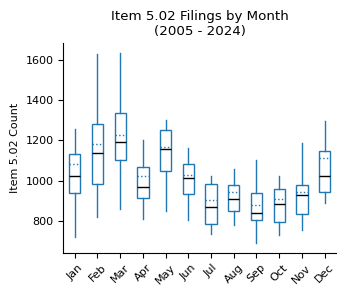

In [165]:
fig, ax = plt.subplots(figsize=(3.5, 3))

counts_month_yr_piv.loc[2005:].boxplot(
    ax=ax,
    grid=False,
    showfliers=False,
    flierprops=dict(marker="o", markersize=3),
    patch_artist=True,
    boxprops=dict(facecolor="white", color="tab:blue"),
    showmeans=True,
    meanline=True,
    meanprops={"color": "tab:blue", "linestyle": ":"},
    medianprops={"color": "black"},
    capprops={"color": "none"},
)

ax.set_title("Item 5.02 Filings by Month\n(2005 - 2024)")
ax.set_xlabel("")
ax.set_ylabel("Item 5.02 Count")
xticklabels = [pd.to_datetime(str(x), format="%m").strftime("%b") for x in range(1, 13)]
ax.set_xticklabels(xticklabels)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [16]:
counts_filedAtClass = (
    structured_data.drop_duplicates(subset=["accessionNo"])
    .groupby(["filedAtClass"])
    .size()
    .sort_values(ascending=False)
    .to_frame(name="Count")
).rename_axis("Publication Time")
counts_filedAtClass["Pct"] = (
    counts_filedAtClass["Count"].astype(int)
    / counts_filedAtClass["Count"].astype(int).sum()
).map("{:.0%}".format)
counts_filedAtClass["Count"] = counts_filedAtClass["Count"].map(lambda x: f"{x:,}")
counts_filedAtClass.index = (
    counts_filedAtClass.index.str.replace("preMarket", "Pre-Market (4:00 - 9:30 AM)")
    .str.replace("marketHours", "Market Hours (9:30 AM - 4:00 PM)")
    .str.replace("afterMarket", "After Market (4:00 - 8:00 PM)")
)
counts_filedAtClass = counts_filedAtClass.reindex(counts_filedAtClass.index[::-1])

print(
    f"Item 5.02 counts by pre-market, regular market hours,\nand after-market publication time (2004 - 2024)."
)
counts_filedAtClass

Item 5.02 counts by pre-market, regular market hours,
and after-market publication time (2004 - 2024).


,Count,Pct
Publication Time,,
other,"4,220",2%
Pre-Market (4:00 - 9:30 AM),"31,005",12%
regularMarket,"67,424",27%
After Market (4:00 - 8:00 PM),"148,307",59%


In [17]:
counts_dayOfWeek = (
    structured_data.drop_duplicates(subset=["accessionNo"])
    .groupby(["dayOfWeek"])
    .size()
    .to_frame(name="Count")
).rename_axis("Day of the Week")
counts_dayOfWeek["Pct"] = (
    counts_dayOfWeek["Count"].astype(int) / counts_dayOfWeek["Count"].astype(int).sum()
).map("{:.0%}".format)
counts_dayOfWeek["Count"] = counts_dayOfWeek["Count"].map(lambda x: f"{x:,}")

print(f"Item 5.02 disclosures by day of the week (2004 - 2024).")
counts_dayOfWeek.loc[["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]]

Item 5.02 disclosures by day of the week (2004 - 2024).


,Count,Pct
Day of the Week,,
Monday,"46,840",19%
Tuesday,"50,634",20%
Wednesday,"47,351",19%
Thursday,"50,749",20%
Friday,"55,380",22%


## Type of Personnel Change


In [161]:
personnel_change_types = (
    structured_data[["year", "accessionNo", "personnelChanges"]]
    .explode(column="personnelChanges")
    .reset_index(drop=True)
)
personnel_change_types = pd.concat(
    [
        personnel_change_types.drop(columns="personnelChanges"),
        pd.json_normalize(personnel_change_types["personnelChanges"]),
    ],
    axis=1,
)
print(f"{len(personnel_change_types):,} personnel changes loaded")
personnel_change_types.head()

474,524 personnel changes loaded


,year,accessionNo,type,departureType,positions,reason,continuedConsultingRole,disagreements,person.name,interim,...,compensationIncreased,compensationDecreased,compensation.onetime,compensation.noCompensation,person.positionsAtOtherCompanies,termEndDate,consultingEndDate,person.familyRelationships,amendmentSummary,oldTermEndDate
0,2004,0001125282-04-004109,departure,resignation,[Chief Financial Officer],Personal considerations to pursue other busine...,True,False,Tracy L. Shellabarger,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2004,0001125282-04-004109,appointment,NaN,[Acting Chief Financial Officer],NaN,NaN,NaN,Theresa E. Wagler,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2004,0001104659-04-025282,departure,retirement,"[Senior Vice President, President, Building Pr...",NaN,NaN,NaN,E. L. (Tom) Thompson,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2004,0001104659-04-025282,appointment,NaN,"[Senior Vice President, President, Building Pr...",NaN,NaN,NaN,Robert C. McPherson III,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2004,0000899715-04-000164,appointment,NaN,[Board of Directors],NaN,NaN,NaN,Allan L. Schuman,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [62]:
changeType = personnel_change_types["type"].value_counts().to_frame()
changeType.index.name = "Personnel Change Type"
changeType.columns = ["Count"]
changeType["Pct."] = changeType["Count"] / changeType["Count"].sum() * 100
changeType["Pct."] = changeType["Pct."].round(1)
changeType["Count"] = changeType["Count"].apply(lambda x: f"{x:,.0f}")

print(f"Types of personnel change if stated in the Item 5.02 filings (2004 - 2024):")
changeType

Types of personnel change if stated in the Item 5.02 filings (2004 - 2024):


,Count,Pct.
Personnel Change Type,,
appointment,"210,156",47.5
departure,"178,777",40.4
amendment,"41,937",9.5
bonus,"8,983",2.0
nomination,"1,908",0.4
refusal,219,0.0


In [63]:
change_type_year = personnel_change_types[["type", "year", "accessionNo"]]
changeType_year_pivot = pd.pivot_table(
    change_type_year,
    index="type",
    columns="year",
    values="accessionNo",
    aggfunc="count",
    fill_value=0,
)

changeType_year_pivot["total"] = changeType_year_pivot.sum(axis=1)
changeType_year_pivot = changeType_year_pivot.sort_values(by="total", ascending=False)
# remove artifacts
changeType_year_pivot = changeType_year_pivot[changeType_year_pivot["total"] >= 18]

changeType_year_pivot

year,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,...,2016,2017,2018,2019,2020,2021,2022,2023,2024,total
type,,,,,,,,,,,,,,,,,,,,,
appointment,3132,10089,11466,13076,12841,10552,10678,10718,10365,10075,...,9603,9306,9455,9390,8975,11357,9708,9356,8551,210156
departure,2273,7731,8578,11211,11687,9800,9031,9247,8901,8731,...,8472,8243,8169,8173,7464,7690,8518,8920,8170,178777
amendment,35,142,835,3860,4481,3320,2722,2593,2438,2262,...,1943,1893,1715,1571,2006,1557,1579,1310,1342,41937
bonus,0,0,191,1085,822,637,658,607,548,483,...,489,424,334,249,308,287,295,233,263,8983
nomination,16,105,114,128,173,121,93,66,90,116,...,77,84,97,94,93,90,62,50,52,1908
refusal,5,23,24,16,16,21,2,7,6,11,...,11,8,10,12,5,2,12,3,7,219


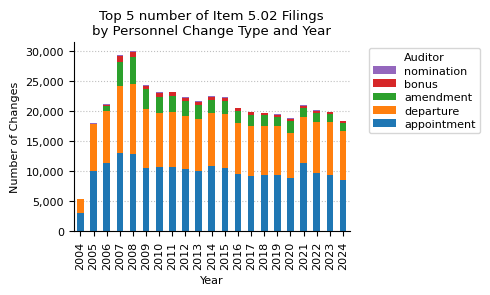

In [75]:
fig, ax = plt.subplots(figsize=(5, 3))

changeType_year_pivot.head(5).drop(columns="total").T.plot(
    kind="bar", stacked=True, ax=ax
)

ax.set_title("Top 5 number of Item 5.02 Filings\nby Personnel Change Type and Year")
ax.set_xlabel("Year")
ax.set_ylabel("Number of Changes")
ax.xaxis.grid(False)
ax.set_axisbelow(True)
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter("{x:,.0f}"))
handles, labels = ax.get_legend_handles_labels()  # reverse order of legend items

ax.legend(
    [h for h in reversed(handles)],
    [l for l in reversed(labels)],
    title="Auditor",
    bbox_to_anchor=(1.05, 1),
    labelspacing=0.3,
    fontsize=8,
)

plt.tight_layout()
plt.show()

## Appointed Positions

In [ ]:
appointments = personnel_change_types[
    personnel_change_types["type"] == "appointment"
].copy()

ceo_patterns = ["ceo", "chief executive officer"]
# check if one of these pattersn is in the array in the 'positions' column, set values to NaN if there is an error
appointments.loc[:, "isCEO"] = appointments["positions"].apply(
    lambda x: (
        any([pattern in str(x).lower() for pattern in ceo_patterns])
        if isinstance(x, list)
        else False
    )
)
cfo_patterns = ["cfo", "chief financial officer"]
appointments.loc[:, "isCFO"] = appointments["positions"].apply(
    lambda x: (
        any([pattern in str(x).lower() for pattern in cfo_patterns])
        if isinstance(x, list)
        else False
    )
)
board_patterns = ["board", "director", "chairman"]
appointments.loc[:, "isBoardMember"] = appointments["positions"].apply(
    lambda x: (
        any([pattern in str(x).lower() for pattern in board_patterns])
        if isinstance(x, list)
        else False
    )
)
appointments.loc[:, "isOther"] = ~appointments["isCEO"] & ~appointments["isBoardMember"]
# assign roles based on conditions
appointments.loc[:, "role"] = appointments.apply(
    lambda row: (
        "CEO" if row["isCEO"] else ("CFO" if row["isCFO"] else ("Board Member" if row["isBoardMember"] else "Other"))
    ),
    axis=1,
)

In [78]:
appointments_role_year = appointments.groupby(["role", "year"]).size().unstack().fillna(0)
appointments_role_year.loc["total"] = appointments_role_year.sum()

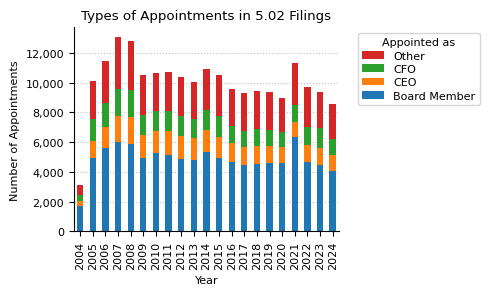

In [81]:
fig, ax = plt.subplots(figsize=(5, 3))

appointments_role_year.T.drop(columns="total").plot(kind="bar", stacked=True, ax=ax)

ax.set_title("Types of Appointments in 5.02 Filings")
ax.set_xlabel("Year")
ax.set_ylabel("Number of Appointments")
ax.xaxis.grid(False)
ax.set_axisbelow(True)
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter("{x:,.0f}"))
handles, labels = ax.get_legend_handles_labels()  # reverse order of legend items

ax.legend(
    [h for h in reversed(handles)],
    [l for l in reversed(labels)],
    title="Appointed as",
    bbox_to_anchor=(1.05, 1),
    labelspacing=0.3,
    fontsize=8,
)

plt.tight_layout()
plt.show()

## Compensation

In this section we analyze the compensation for new appointments including

- one-time payments
- annual cash values
- equity compensation


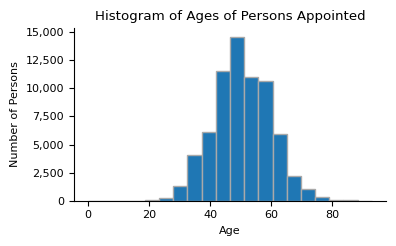

Average Age: 50.51
Min Age: 20.00
Max Age: 93.00
Median Age: 50.00


In [ ]:
appointments = personnel_change_types[personnel_change_types["type"] == "appointment"]

fig, ax = plt.subplots(figsize=(4, 2.5))
ax.hist(appointments["person.age"].dropna(), bins=20, edgecolor="darkgrey")
ax.set_title("Histogram of Ages of Persons Appointed")
ax.set_xlabel("Age")
ax.set_ylabel("Number of Persons")
ax.grid(axis="y")
ax.set_axisbelow(True)
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter("{x:,.0f}"))
plt.tight_layout()
plt.show()

# exclude outliers below 18 and above 100
appointments = appointments[
    (appointments["person.age"] >= 18) & (appointments["person.age"] < 100)
]

mean_age = appointments["person.age"].mean()
min_age = appointments["person.age"].min()
max_age = appointments["person.age"].max()
median_age = appointments["person.age"].median()

print(f"Average Age: {mean_age:.2f}")
print(f"Min Age: {min_age:.2f}")
print(f"Max Age: {max_age:.2f}")
print(f"Median Age: {median_age:.2f}")

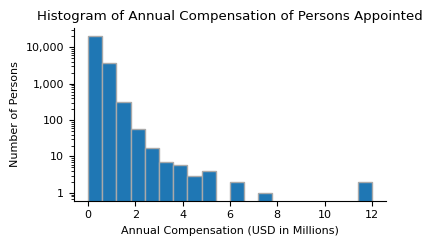

Average Compensation: 383,013.58
Min Compensation: 0.00
Max Compensation: 12,000,000.00
Median Compensation: 330,000.00


In [ ]:
fig, ax = plt.subplots(figsize=(4, 2.5))

# convert the amounts to numbers, stripping dollar signs
compensation_annual = pd.to_numeric(
    appointments["compensation.annual"].str.replace(r"[\$,]", "", regex=True),
    errors="coerce",
).dropna()

ax.hist(compensation_annual, bins=20, edgecolor="darkgrey")
ax.set_title("Histogram of Annual Compensation of Persons Appointed")
ax.set_xlabel("Annual Compensation (USD in Millions)")
ax.set_ylabel("Number of Persons")
ax.set_yscale("log")
ax.grid(axis="y")
ax.set_axisbelow(True)
ax.xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, p: f"{x/1_000_000:,.0f}"))
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter("{x:,.0f}"))
plt.tight_layout()
plt.show()

# exclude outliers below 0 and above 1e7
# appointments = appointments[(appointments["compensation.annual"] >= 0) & (appointments["compensation.annual"] < 1e7)]

mean_compensation = compensation_annual.mean()
min_compensation = compensation_annual.min()
max_compensation = compensation_annual.max()
median_compensation = compensation_annual.median()

print(f"Average Compensation: {mean_compensation:,.2f}")
print(f"Min Compensation: {min_compensation:,.2f}")
print(f"Max Compensation: {max_compensation:,.2f}")
print(f"Median Compensation: {median_compensation:,.2f}")

In [97]:
# check how many compensations have an equity component
numEquityComponent = appointments["compensation.equity"].notnull().sum()

print(
    f"Appointments with including equity component in the Item 5.02 filings (2004 - 2024):"
)
print(
    f"Number of appointments with an equity component: {numEquityComponent:,} = {numEquityComponent / len(appointments):.1%} of all appointments."
)

Appointments with including equity component in the Item 5.02 filings (2004 - 2024):
Number of appointments with an equity component: 20,845 = 30.1% of all appointments.


## Departures


In [99]:
departures = personnel_change_types[personnel_change_types["type"] == "departure"]
departureType_year = personnel_change_types[
    ["departureType", "year", "accessionNo", "disagreements"]
].explode("departureType")

departureType_year_pivot = pd.pivot_table(
    departureType_year,
    index="departureType",
    columns="year",
    values="accessionNo",
    aggfunc="count",
    fill_value=0,
)

departureType_year_pivot["total"] = departureType_year_pivot.sum(axis=1)
departureType_year_pivot = departureType_year_pivot.sort_values(
    by="total", ascending=False
)

departureType_year_pivot

year,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,...,2016,2017,2018,2019,2020,2021,2022,2023,2024,total
departureType,,,,,,,,,,,,,,,,,,,,,
resignation,1578,5304,5670,7297,7855,6438,5833,5898,5574,5287,...,4704,4595,4348,4303,3989,3956,4248,4622,4256,106144
other,314,1098,1384,1840,1683,1529,1642,1637,1452,1645,...,1917,1823,1908,1982,1803,1937,2377,2200,2042,35805
retirement,282,996,1087,1381,1363,1075,1011,1132,1236,1260,...,1266,1270,1400,1403,1217,1372,1338,1368,1265,25347
termination,68,208,293,500,611,619,390,404,475,397,...,409,372,364,319,312,229,355,566,428,8052


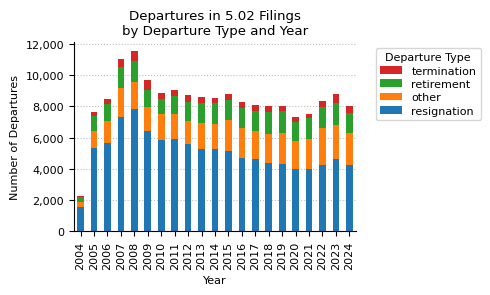

In [103]:
fig, ax = plt.subplots(figsize=(5, 3))

departureType_year_pivot.drop(columns="total").T.plot(kind="bar", stacked=True, ax=ax)

ax.set_title("Departures in 5.02 Filings\nby Departure Type and Year")
ax.set_xlabel("Year")
ax.set_ylabel("Number of Departures")
ax.xaxis.grid(False)
ax.set_axisbelow(True)
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter("{x:,.0f}"))
handles, labels = ax.get_legend_handles_labels()  # reverse order of legend items

ax.legend(
    [h for h in reversed(handles)],
    [l for l in reversed(labels)],
    title="Departure Type",
    bbox_to_anchor=(1.05, 1),
    labelspacing=0.3,
    fontsize=8,
)

plt.tight_layout()
plt.show()

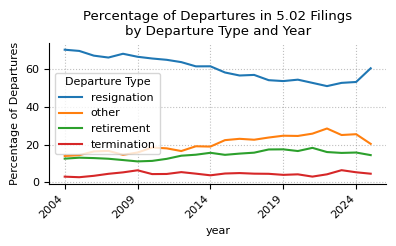

In [ ]:
percentag_departure_pivot = departureType_year_pivot.copy()
percentag_departure_pivot.loc["total"] = percentag_departure_pivot.sum(axis=0)
percentag_departure_pivot = (
    percentag_departure_pivot.div(percentag_departure_pivot.loc["total"], axis=1) * 100
)

fig, ax = plt.subplots(figsize=(4, 2.5))
percentag_departure_pivot.drop("total").T.plot(kind="line", stacked=False, ax=ax)
ax.legend(title="Departure Type")
ax.set_ylabel("Percentage of Departures")
ax.set_title("Percentage of Departures in 5.02 Filings\nby Departure Type and Year")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

## Departures connected to disagreements


In [108]:
disagreements_year_pivot = departures.pivot_table(
    # departures,
    index="year",
    values=["disagreements"],
    aggfunc=lambda x: (x == True).sum(),
    fill_value=0,
)

departures_year_pivot = departures.pivot_table(
    index="year",
    values=["accessionNo"],
    aggfunc="count",
    fill_value=0,
)

disagreements_year_pivot = disagreements_year_pivot.T
disagreements_year_pivot["total"] = disagreements_year_pivot.sum(axis=1)
disagreements_year_pivot = disagreements_year_pivot.sort_values(
    by="total", ascending=False
)
disagreements_year_pivot

year,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,...,2016,2017,2018,2019,2020,2021,2022,2023,2024,total
disagreements,25,61,84,87,103,90,81,54,61,48,...,65,57,44,32,45,17,70,46,48,1212


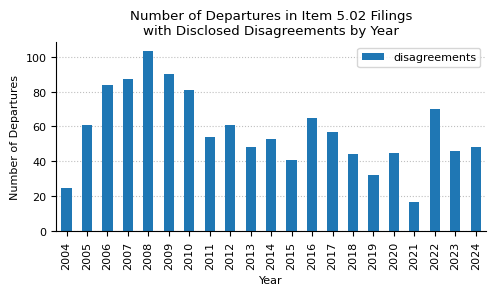

In [ ]:
fig, ax = plt.subplots(figsize=(5, 3))

disagreements_year_pivot.T.drop("total").plot(kind="bar", stacked=False, ax=ax)

ax.set_title(
    "Number of Departures in Item 5.02 Filings\nwith Disclosed Disagreements by Year"
)
ax.set_xlabel("Year")
ax.set_ylabel("Number of Departures")
ax.xaxis.grid(False)
ax.set_axisbelow(True)
plt.tight_layout()
plt.show()

In [113]:
disagreements_year_pivot = departures.pivot_table(
    # departures,
    index="year",
    values=["disagreements"],
    aggfunc=lambda x: (x == True).sum(),
    fill_value=0,
)

departures_year_pivot = departures.pivot_table(
    index="year",
    values=["accessionNo"],
    aggfunc="count",
    fill_value=0,
).rename(columns={"accessionNo": "departures"})

percentage_disagreements = (
    disagreements_year_pivot["disagreements"]
    / departures_year_pivot["departures"]
    * 100
).fillna(0)
percentage_disagreements = percentage_disagreements.apply(lambda x: f"{x:.2f}")

departures_year_pivot["disagreements"] = disagreements_year_pivot["disagreements"]
departures_year_pivot["disagreements_percentage"] = percentage_disagreements
departures_year_pivot

,departures,disagreements,disagreements_percentage
year,,,
2004,2273,25,1.10
2005,7731,61,0.79
2006,8578,84,0.98
2007,11211,87,0.78
2008,11687,103,0.88
2009,9800,90,0.92
2010,9031,81,0.90
2011,9247,54,0.58
2012,8901,61,0.69


## Amendments

This section includes statistics of amendments of contracts.
First we will investigate boolean statistics and then analyze which part of the compensation was changed.

In [115]:
amendments = personnel_change_types[personnel_change_types["type"] == "amendment"]
columns_to_check_amendments = [
    "termShortened",
    "termExtended",
    "compensationIncreased",
    "compensationDecreased",
]
amendments_summary = (
    amendments[columns_to_check_amendments]
    .apply(lambda x: x.value_counts())
    .T.fillna(0)
    .astype(int)
)
amendments_summary["False % tot."] = (
    (amendments_summary[False] / len(amendments)) * 100
).map("{:.2f}".format)
amendments_summary["True % tot."] = (
    (amendments_summary[True] / len(amendments)) * 100
).map("{:.2f}".format)
print(f"Summary of the {len(amendments):,} amendments in Item 5.02 filings (2004 - 2024).")
amendments_summary

Summary of the 41,937 amendments in Item 5.02 filings (2004 - 2024).


,False,True,False % tot.,True % tot.
termShortened,893,98,2.13,0.23
termExtended,802,3997,1.91,9.53
compensationIncreased,1010,5100,2.41,12.16
compensationDecreased,968,1049,2.31,2.50


In [117]:
amendments = personnel_change_types[personnel_change_types["type"] == "amendment"]
columns_to_check_amendments = ["compensation.onetime", "compensation.annual", "compensation.equity"]
compensation_summary = amendments[columns_to_check_amendments].count().astype(int)
percentage_summary = (compensation_summary / len(amendments) * 100).round(2)
amendments_summary_df = pd.DataFrame([compensation_summary, percentage_summary], index=["Count", "Percentage"]).T
amendments_summary_df["Count"] = amendments_summary_df["Count"].astype(int)
amendments_summary_df

,Count,Percentage
compensation.onetime,1988,4.74
compensation.annual,18453,44.00
compensation.equity,9251,22.06


## Organizational Changes

In this section we have a look at reported organizational changes.

In [139]:
org_changes = (
    structured_data[["accessionNo", "year", "organizationChanges"]]
    .dropna(subset="organizationChanges")
    .copy()
    .reset_index(drop=True)
)
org_changes = pd.concat(
    [
        org_changes[["accessionNo", "year"]],
        pd.json_normalize(org_changes["organizationChanges"]),
    ],
    axis=1,
)
org_changes

print(
    f"There are {len(org_changes):,} unique Form 8-K filings with a disclosed organization change."
)
org_changes

There are 39,640 unique Form 8-K filings with a disclosed organization change.


,accessionNo,year,organ,details,sizeIncrease,affectedPersonnel,sizeDecrease,created,abolished
0,0000899715-04-000164,2004,Board of Directors,Expansion of the board,True,[Allan L. Schuman],NaN,NaN,NaN
1,0001193125-04-145794,2004,Board of Directors,"Appointment of Marvin S. Hausman, MD to the Board",True,"[Marvin S. Hausman, MD]",NaN,NaN,NaN
2,0000950137-04-007089,2004,Board of Directors,Election of Frederick H. Schneider as a Class ...,True,NaN,NaN,NaN,NaN
3,0000066756-04-000085,2004,Board of Directors,Amendments to bylaws including shareholder nom...,False,NaN,False,NaN,NaN
4,0001104659-04-025731,2004,Board of Directors,Reduction in size from ten members to nine,NaN,NaN,True,NaN,NaN
...,...,...,...,...,...,...,...,...,...
39635,0001171843-24-007128,2024,Audit Committee,The Company intends to maintain a two-member A...,False,"[W. Thorpe McKenzie, Jan-Paul Waldin]",False,False,False
39636,0001331757-24-000239,2024,Board of Directors,Committee assignments for 2025 were finalized.,False,"[Jeff Austin III, J. Mark Riebe, Rufus Cormier...",False,False,False
39637,0001104659-24-132872,2024,Board of Directors,"Termination of the International Seaways, Inc....",False,NaN,False,False,False
39638,0001193125-24-287188,2024,Board of Directors,Increased the size of the Board to fifteen dir...,True,"[Jacqueline Allard, Somesh Khanna]",False,False,False


In [140]:
org_changes["organ"].value_counts().head()

organ
Board of Directors        31805
Compensation Committee      452
Audit Committee             404
Board of Trustees           253
Equity Incentive Plan       228
Name: count, dtype: int64

In [141]:
board_changes = org_changes[org_changes["organ"] == "Board of Directors"].copy()

# Define classification function
def classify_size_change(row):
    
    if row["sizeIncrease"]:
        return "increase"
    elif row["sizeDecrease"]:
        return "decrease"
    else:
        return "no size change"
    
board_changes["sizeChange"] = board_changes.apply(classify_size_change, axis=1)

print("Size changes of the Board of Directors disclosed in Item 5.02 over the full period (2004 - 2024).")
print(board_changes["sizeChange"].value_counts())

Size changes of the Board of Directors disclosed in Item 5.02 over the full period (2004 - 2024).
sizeChange
increase          25566
no size change     5518
decrease            721
Name: count, dtype: int64


In [142]:
counts_board_size_change_yr_piv = (
    board_changes.drop_duplicates(subset=["accessionNo"])
    .groupby(["year", "sizeChange"])
    .size()
    .unstack()
    .fillna(0)
).astype(int)
print(f"Size changes of the Board of Directors disclosed in Item 5.02 filings by year (2004 - 2024).")
counts_board_size_change_yr_piv.T

Size changes of the Board of Directors disclosed in Item 5.02 filings by year (2004 - 2024).


year,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
sizeChange,,,,,,,,,,,,,,,,,,,,,
decrease,4,12,20,35,28,32,14,29,21,32,...,43,29,40,39,40,41,44,51,58,82
increase,296,983,1132,1229,1275,1107,1136,1183,1234,1226,...,1249,1279,1259,1304,1276,1335,1648,1417,1394,1296
no size change,21,100,141,286,352,294,297,281,252,268,...,281,249,280,247,308,309,281,330,329,348


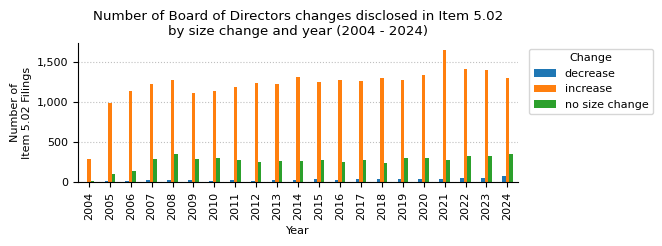

In [153]:
counts_bsc_yr = counts_board_size_change_yr_piv.stack().reset_index(name="count")

fig, ax = plt.subplots(figsize=(7, 2.5))
counts_board_size_change_yr_piv.plot(kind="bar", ax=ax, legend=True)
ax.legend(title="Change", loc="upper right", bbox_to_anchor=(1.32, 1))
ax.set_title("Number of Board of Directors changes disclosed in Item 5.02\nby size change and year (2004 - 2024)")
ax.set_xlabel("Year")
ax.set_ylabel("Number of\nItem 5.02 Filings")
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter("{x:,.0f}"))
ax.grid(axis="x")
ax.set_axisbelow(True)
plt.tight_layout()
plt.show()

## Bonus Plans

This section gives a quick overview of the bonus plans reported in the Item 5.02 filings.

For this section, we downloaded all filings including a bonus plan change from the [Form 8-K Item 5.02 Structured Data API](https://sec-api.io/docs/form-8k-data-item5-2-search-api) and prepared a second dataframe.
For this, we exploded the list of bonus plans and saved it to disk. This way, we can start with the analysis right away.

In [162]:
bonus_data = (
    structured_data[["accessionNo", "year", "bonusPlans"]]
    .copy()
    .explode(column="bonusPlans")
    .dropna(subset=["bonusPlans"])
    .reset_index(drop=True)
)

bonus_data = pd.concat(
    [
        bonus_data[["accessionNo", "year"]],
        pd.json_normalize(bonus_data["bonusPlans"]),
    ],
    axis=1,
)
print(f"{len(bonus_data):,} bonus plan disclosures loaded.")
bonus_data

50,189 bonus plan disclosures loaded.


,accessionNo,year,specificIndividuals,eligibleIndividuals,compensation.cash,conditional,conditions,compensation.equity,compensation.equityDetails,specificRoles,generalEmployee,eligibleRoles
0,0001104659-04-025325,2004,True,[Dale Brown],20% of annual salary,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000950123-04-010249,2004,True,[Michael P. Huseby],Annual bonus with a target of 80% of his annua...,True,Performance-based vesting for conjunctive righ...,"Annual awards of 10,000 restricted shares of C...",Four-year cliff vesting,NaN,NaN,NaN
2,0000703701-04-000042,2004,True,[Benjamin M. Cutler],"Minimum Annual Bonus of $166,666 for 2004 and ...",True,Achievement of performance targets,Options to purchase 9.9% of the common stock,Vesting over 5 years,NaN,NaN,NaN
3,0001204560-04-000031,2004,True,[Shant Koumriqian],Targeted annual bonus of 40%,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0001104659-04-027002,2004,True,"[Dr. Hahn, Mr. Howard, Mr. Raymond, Mr. Rice]","$15,000 annual retainer",False,NaN,"30,000 stock options",25% vesting immediately with an additional 25%...,False,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
50184,0001493152-24-052707,2024,True,"[Pete O'Heeron, Hamid Khoja]",NaN,NaN,NaN,"406,339 shares of common stock for Pete O'Heer...","One fourth (1/4th) vest on December 27, 2025, ...",NaN,NaN,NaN
50185,0001193125-24-287183,2024,True,[Matt Reback],"$175,000",True,Subject to the conditions set forth in the Emp...,NaN,NaN,False,False,NaN
50186,0001213900-24-114015,2024,True,[Dr. William J. McGann],5% of annual base salary,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50187,0001193125-24-287188,2024,True,"[Christopher M. Gorman, Clark Khayat, Andrew J...",NaN,True,Achievement of regulatory capital requirements...,Share-settled performance-based equity awards,Vesting in January 2027 based on regulatory ca...,False,False,NaN


In [157]:
bool_variables_to_analyze = [
    "specificRoles",
    "generalEmployee",
    "specificIndividuals",
    "conditional",
]

var_to_label = {
    "specificRoles": "Specific Positions are eligible",
    "generalEmployee": "General Employees are eligible",
    "specificIndividuals": "Specific Individuals are eligible",
    "conditional": "Conditional Bonus",
}


total_samples = len(bonus_data)
# Create a row for the total samples
total_row = pd.DataFrame(
    {
        "Samples": [f"{total_samples:,.0f}"],
        "Pct.": [""],
        "Pct. tot.": [100],
    },
    index=pd.MultiIndex.from_tuples([("Total", "")], names=["Variable", "Value"]),
)


bool_variables_stats = []

for variable in bool_variables_to_analyze:
    variable_stats = (
        bonus_data[variable]
        .value_counts()
        .to_frame()
        .reset_index()
        .rename(columns={variable: "value"})
    )
    variable_stats = variable_stats.sort_values(by="value", ascending=False)
    variable_stats["pct"] = (
        variable_stats["count"] / variable_stats["count"].sum() * 100
    ).round(1)
    variable_stats["pct_tot"] = (variable_stats["count"] / total_samples * 100).round(1)
    variable_stats.index = pd.MultiIndex.from_tuples(
        [(variable, row["value"]) for _, row in variable_stats.iterrows()],
    )
    variable_stats.drop(columns="value", inplace=True)

    bool_variables_stats.append(variable_stats)

bool_variables_stats = pd.concat(bool_variables_stats, axis=0)
bool_variables_stats.index.set_names(["Variable", "Value"], inplace=True)
bool_variables_stats.rename(
    index=var_to_label,
    columns={"count": "Samples", "pct": "Pct.", "pct_tot": "Pct. tot."},
    inplace=True,
)
bool_variables_stats["Samples"] = bool_variables_stats["Samples"].apply(
    lambda x: f"{x:,.0f}"
)


bool_variables_stats = pd.concat([total_row, bool_variables_stats])


print(
    f"Number of Bonus Plans disclosed in Item 5.02\nby their disclosed characteristics (2004 - 2024):"
)
bool_variables_stats

Number of Bonus Plans disclosed in Item 5.02
by their disclosed characteristics (2004 - 2024):


Samples  Pct.  Pct. tot.
Variable                          Value                         
Total                                    50,189            100.0
Specific Positions are eligible   True    9,181  27.4       18.3
                                  False  24,280  72.6       48.4
General Employees are eligible    True    6,632  22.2       13.2
                                  False  23,295  77.8       46.4
Specific Individuals are eligible True   32,642  69.6       65.0
                                  False  14,230  30.4       28.4
Conditional Bonus                 True   32,414  77.8       64.6
                                  False   9,254  22.2       18.4

In [158]:
columns_to_check_bonus = ["compensation.cash", "compensation.equity"]
compensation_summary = bonus_data[columns_to_check_bonus].count().astype(int)
percentage_summary = (compensation_summary / len(bonus_data) * 100).round(2)
bonus_summary_df = pd.DataFrame([compensation_summary, percentage_summary], index=["Count", "Percentage"]).T
bonus_summary_df["Count"] = bonus_summary_df["Count"].astype(int)
bonus_summary_df.rename(columns={"Count": "Total Count", "Percentage": "Share (%)"}, inplace=True)
bonus_summary_df = bonus_summary_df.rename(index={"compensation.cash": "Cash Compensation",
                                                  "compensation.equity": "Equity Compensation"})
print("Number of Bonus Plans disclosed in Item 5.02 filings (2004 - 2024) with compensation details.")
bonus_summary_df

Number of Bonus Plans disclosed in Item 5.02 filings (2004 - 2024) with compensation details.


,Total Count,Share (%)
Cash Compensation,29494,58.77
Equity Compensation,26408,52.62
